In [154]:
### importing the necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from surprise import Dataset,Reader
from surprise import KNNWithMeans
from surprise import accuracy
import time
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
col_names = ['UserID', 'ProductID','Rating','TimeStamp']
# Importing the dataset
dataset = pd.read_csv('ratings_Electronics_Ver3.csv',names=col_names ,header = None)

In [6]:
dataset.head()

,UserID,ProductID,Rating,TimeStamp
0,ratings_Electronics.csv,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [26]:
# Dropping first row as it has manual error entering user id
dataset.drop(dataset.index[[0]], inplace=True)
dataset.shape

(7824482, 3)

In [11]:
#Dropping TimeStamp as it is not required
dataset.drop(["TimeStamp"],axis=1,inplace=True)

In [32]:
dataset.shape

(7824482, 3)

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824483 entries, 0 to 7824482
Data columns (total 3 columns):
UserID       object
ProductID    object
Rating       float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [42]:
dataset.reset_index()

,index,UserID,ProductID,Rating
0,1,A2CX7LUOHB2NDG,0321732944,5.0
1,2,A2NWSAGRHCP8N5,0439886341,1.0
2,3,A2WNBOD3WNDNKT,0439886341,3.0
3,4,A1GI0U4ZRJA8WN,0439886341,1.0
4,5,A1QGNMC6O1VW39,0511189877,5.0
...,...,...,...,...
7824477,7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824478,7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824479,7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0
7824480,7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.0


In [43]:
dataset.isnull().sum()

UserID       1
ProductID    1
Rating       1
dtype: int64

In [47]:
# Delete NaN row
dataset.dropna(how='any', inplace=True)

In [48]:
dataset.isnull().sum()

UserID       0
ProductID    0
Rating       0
dtype: int64

In [58]:
# Count of unique users
print("Number of unique users: ",len(dataset['UserID'].unique()))
users = dataset['UserID']

Number of unique users:  4201696


In [61]:
# Count of unique products
print("Number of unique products: ",len(dataset['ProductID'].unique()))

Number of unique products:  476001


In [221]:
# Various ratings given by user.
dataset['Rating'].value_counts() 

5.0    4347540
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: Rating, dtype: int64

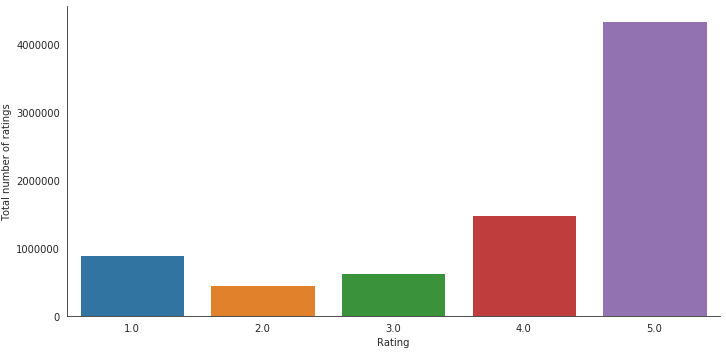

In [220]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=dataset, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [222]:
# Take a subset of the dataset to make it less sparse/ denser. 
# For example, keep the users only who has given 50 or more number of ratings
# Making it 100 as data set is still dense when 
# considered users only who has given 50+ ratings
User_Count = dataset["UserID"].value_counts()
User_Rating = dataset[dataset["UserID"].isin(User_Count[User_Count >= 100].index)]
User_Rating.shape

(44209, 3)

In [223]:
User_Rating.head()

,UserID,ProductID,Rating
118,AT09WGFUM934H,0594481813,3.0
178,A17HMM1M7T9PJ1,0970407998,4.0
631,A3TAS1AG6FMBQW,0972683275,5.0
1777,A18S2VGUH9SCV5,1400501776,4.0
2162,A5JLAU2ARJ0BO,1400532655,1.0


In [224]:
User_Rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44209 entries, 118 to 7824444
Data columns (total 3 columns):
UserID       44209 non-null object
ProductID    44209 non-null object
Rating       44209 non-null float64
dtypes: float64(1), object(2)
memory usage: 1.3+ MB


Popularity Based Model Prediction

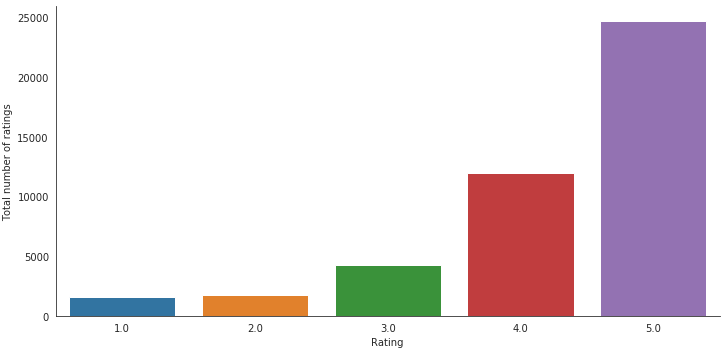

In [225]:
# Check the distribution of ratings based on reduced dataset 
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=User_Rating, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [226]:
# Number of unique user id and product id in the reuced dataset
print('Number of unique USERS in Raw data = ', User_Rating['UserID'].nunique())
print('Number of unique ITEMS in Raw data = ', User_Rating['ProductID'].nunique())

Number of unique USERS in Raw data =  289
Number of unique ITEMS in Raw data =  22635


Reconedation based on pure popularity averaging out total rating

In [228]:
Top_Reco1 = User_Rating.groupby(['ProductID'])['Rating'].mean().reset_index(name='MeanRating')
Top_Reco1.sort_values('MeanRating', ascending=False).head(20)

,ProductID,MeanRating
22634,B00LKG1MC8,5.0
17086,B006ZC5PDE,5.0
17084,B006ZB39QU,5.0
8286,B001EQ7H82,5.0
8287,B001EQQW1A,5.0
8288,B001ES5D5Y,5.0
8289,B001ET5ZWE,5.0
17082,B006ZAHMPA,5.0
17081,B006ZA8RCC,5.0
8292,B001ET6QFY,5.0


Popularity rating based on 5.0 rating given by user

In [229]:
filt = User_Rating['Rating']>=5.0
Top_Rating = User_Rating[User_Rating['Rating'] >=5]
Top_Rating.shape

(24706, 3)

Publishing new Top 20 recomendation based on popularity using another method. The earlier methods for popularity based recommendations was based on pure average of entire rating given(there were more than 20 products have an average rating of 5.0, so we cannot justiy the top 20 count. This method below uses only top rating of 5.0 and take number of ratings to get the top count

In [249]:

Top_Reco = Top_Rating.groupby(['ProductID']).size().reset_index(name='Counts')
Top_Reco.sort_values(by=['Counts'], ascending=False, inplace=True)
Top_Reco['Rating_Rank'] = Top_Reco['Counts'].rank(ascending= 0)
Top_Reco.head(20)

,ProductID,Counts,Rating_Rank
7635,B003ES5ZUU,54,1.0
3543,B000N99BBC,37,2.0
8747,B004CLYEDC,35,3.0
11469,B00829TIEK,33,4.5
8749,B004CLYEFK,33,4.5
11558,B0088CJT4U,31,6.0
14015,B00G4UQ6U8,30,7.0
11377,B007WTAJTO,28,8.5
11471,B0082E9K7U,28,8.5
12950,B00BOHNYTW,27,10.5


In [156]:
# Transforming data to surprise format
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(User_Rating, reader)

In [157]:
data

Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [158]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.30,random_state=123)

In [160]:
type(trainset)

surprise.trainset.Trainset

In [161]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [162]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [163]:
test_pred

[Prediction(uid='A3TAS1AG6FMBQW', iid='B00ITI058W', r_ui=5.0, est=4.315183450429352, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3J8A5L5AF5TX9', iid='B0028N6VN2', r_ui=4.0, est=4.315183450429352, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A36K2N527TXXJN', iid='B00EUTKFMK', r_ui=5.0, est=4.315183450429352, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3OXHLG6DIBRW8', iid='B001CSCB6U', r_ui=4.0, est=4.315183450429352, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A18HE80910BTZI', iid='B00CPKLBIS', r_ui=4.0, est=4.315183450429352, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3T7V207KRDE2O', iid='B004SBBD1C', r_ui=4.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A22CW0ZHY3NJH8', iid='B00HZ9GNGY', r_ui=5.0, est=4.6303547

In [164]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.9775


0.9774560774247194

Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products

In [165]:
testset_new = trainset.build_anti_testset()

In [166]:
len(testset_new)

1007100

In [167]:
testset_new[0:5] # Rating given is the mean rating which has no value

[('A3J8A5L5AF5TX9', 'B0015DYMVO', 4.315183450429352),
 ('A3J8A5L5AF5TX9', 'B009L946F6', 4.315183450429352),
 ('A3J8A5L5AF5TX9', 'B0013DXVYK', 4.315183450429352),
 ('A3J8A5L5AF5TX9', 'B005MZU0MG', 4.315183450429352),
 ('A3J8A5L5AF5TX9', 'B001JU9NZ8', 4.315183450429352)]

In [183]:
predictions = algo.test(testset_new)

In [184]:
predictions_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in predictions])

In [185]:
predictions_df.columns = ["UserID","ProductID","est_rating"]
predictions_df.sort_values(by = ["UserID", "est_rating"],ascending=False,inplace=True)

In [186]:
Top_5_Reco = predictions_df.groupby("UserID").head(5).reset_index(drop=True)

In [188]:
Top_5_Reco.head(20)

,UserID,ProductID,est_rating
0,AZMY6E8B52L2T,B004PWKRK2,5.0
1,AZMY6E8B52L2T,B006GMIMNI,5.0
2,AZMY6E8B52L2T,B00066FHHO,5.0
3,AZMY6E8B52L2T,B00FDLDCD8,5.0
4,AZMY6E8B52L2T,B006OM75I8,5.0
5,AYB4ELCS5AM8P,B008MF3X9K,5.0
6,AYB4ELCS5AM8P,B00FDLDCD8,5.0
7,AYB4ELCS5AM8P,B00F9ZQQ8Q,5.0
8,AYB4ELCS5AM8P,B006OM75I8,5.0
9,AYB4ELCS5AM8P,B00EFE9OAE,5.0


In [201]:
# Taking input from User for top recomendation
# Enter 'userID' for top 5 recommendations 
val = input("Enter User Id for Recomendation: ") 
Recomendation = Top_5_Reco[Top_5_Reco['UserID']== val]
print('Top 5 Recomendation for User',val)
Recomendation[['ProductID','est_rating']]

Enter User Id for Recomendation: AVPNQUVZWMDSX
Top 5 Recomendation for User AVPNQUVZWMDSX


,ProductID,est_rating
15,B0013DXVYK,5.0
16,B00066FHHO,5.0
17,B007W0XHK6,5.0
18,B001TH7GVE,5.0
19,B004VM0SE6,5.0


Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user. The Popularity based model has recommended the same set of 5 products to each of the user but Collaborative Filtering based model has recommended entire different list based on the user past purchase history